In [1]:
import numpy as np
import zarr
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm, trange

from gltfraytracer import Scene3D

In [2]:
# Field of view
fov_factor = 2.0
fov = 2 * np.arctan(fov_factor / 2) * 180/np.pi

In [3]:
# Plane U
z_u = 0.0
n_u = 40
size_u = 10.0
pitch_u = size_u / n_u

# Plane V
z_v = 95.0
n_v = 800
size_v = 200.0
pitch_v = size_v / n_v

# View chunks.
chunk_v = 25
n_chunk = n_v//chunk_v

print('[Sampled Light Field]')
print('Plane U:    {:4} × {:4.2f} mm = {:5} mm    z_u = {:5} mm'.format(n_u, pitch_u, size_u, z_u))
print('Plane V:    {:4} × {:4.2f} mm = {:5} mm    z_v = {:5} mm'.format(n_v, pitch_v, size_v, z_v))
print('           ({:2}×{:2})'.format(n_chunk, chunk_v))

print('\n[Retina Estimate with FoV = {:4.1f}°]'.format(fov))
print('Focus at U: {:7.2f}'.format(fov_factor * z_u / pitch_u))
print('Focus at V: {:7.2f}'.format(fov_factor * z_v / pitch_v))
print('Focus at ∞: {:7.2f}'.format(fov_factor * abs(z_u - z_v) / max(pitch_u, pitch_v)))

print('\nNumber of rays: {:,}'.format((n_u * n_v)**2))

[Sampled Light Field]
Plane U:      40 × 0.25 mm =  10.0 mm    z_u =   0.0 mm
Plane V:     800 × 0.25 mm = 200.0 mm    z_v =  95.0 mm
           (32×25)

[Retina Estimate with FoV = 90.0°]
Focus at U:    0.00
Focus at V:  760.00
Focus at ∞:  760.00

Number of rays: 1,024,000,000


In [4]:
def bytesize_string(nbytes):
    unit =          ['B',  'KiB' ,  'MiB' ,  'GiB' ,  'TiB' ,  'PiB' ,  'EiB' ,  'ZiB' ,  'YiB' ]
    size = np.array([ 1 , 1/2**10, 1/2**20, 1/2**30, 1/2**40, 1/2**50, 1/2**60, 1/2**70, 1/2**80]) * nbytes
    order_of_magnitude = np.argmax(size < 1.0) - 1
    return '{} {}'.format(size[order_of_magnitude], unit[order_of_magnitude])

def array_stats(a):
    print('{} × {} = {} | min: {}, max: {}, avg: {}'.format(a.shape, a.dtype, bytesize_string(a.nbytes), np.amin(a), np.amax(a), np.average(a)))
    
def display_image(values):
    display(Image.fromarray((np.flip(np.swapaxes(values, 0, 1), axis=0) * 255.0).astype(np.uint8)))

def sampling_lattice(n, pitch=1.0):
    return (np.arange(n, dtype=np.float32) - (n - 1)/2) * pitch

def dot(a, b):
    return np.einsum('...i,...i', a, b)

In [5]:
lattice_u = sampling_lattice(n_u, pitch_u)
lattice_v = sampling_lattice(n_v, pitch_v).reshape(n_chunk, chunk_v)

In [6]:
%%time

print('Creating the light field array...')
light_field = zarr.open('data/sponza_sampled_rt.zarr', mode='w', shape=(n_u, n_chunk, chunk_v, n_u, n_chunk, chunk_v, 3), chunks=(n_u, 1, chunk_v, n_u, 1, chunk_v, 3), dtype=np.float32)

light_values = np.array([[1.2, 1.2, 1.2], [0.8, 0.8, 0.8], [0.6, 0.6, 0.6]])
light_directions = np.array([[0.5, -0.7, 0.5], [-0.5, 0.7, -0.5], [0.0, -0.7, -0.7]])
light_directions /= np.sqrt(dot(light_directions, light_directions))[..., np.newaxis]

rotation = np.array([[0.0, 0.0, 1.0],
                     [0.0, 1.0, 0.0],
                     [1.0, 0.0, 0.0]])

translation = np.array([-150.0, -225.0, -800.0])

print('Loading the scene...')
scene = Scene3D('../models/gltf/sponza/Sponza.gltf', rotation, translation)

print('Casting rays...')
for idx_chunk, idy_chunk in tqdm(np.ndindex(n_chunk, n_chunk), total=light_field.nchunks):
    ray_origins    = np.tile(np.stack(np.broadcast_arrays(lattice_u[    :    ].reshape(n_u,    1   , 1, 1), lattice_u[    :    ].reshape(1, 1, n_u,    1   ), -z_u), axis=-1), ( 1 , chunk_v,  1 , chunk_v, 1)).reshape(-1, 3)
    ray_directions = np.tile(np.stack(np.broadcast_arrays(lattice_v[idx_chunk].reshape( 1 , chunk_v, 1, 1), lattice_v[idy_chunk].reshape(1, 1,  1 , chunk_v), -z_v), axis=-1), (n_u,    1   , n_u,    1   , 1)).reshape(-1, 3) - ray_origins
    ray_directions /= np.sqrt(dot(ray_directions, ray_directions))[..., np.newaxis]

    # Ray cast scene.
    ray_colors = scene.rayCast(ray_origins, ray_directions, light_values, light_directions).astype(np.float32)

    # Clip ray values inside [0, 1].
    ray_colors = np.clip(ray_colors, 0.0, 1.0)

    # Store ray values.
    light_field[:, idx_chunk, :, :, idy_chunk, :, :] = ray_colors.reshape(n_u, chunk_v, n_u, chunk_v, 3)

scene.release()

display(light_field.info)

Creating the light field array...
Loading the scene...
Scene AABB:
[-1332.80712891  -351.44249725 -2720.94592285]
[ 955.42602539 1204.43322754  999.90808105]
Casting rays...


  0%|          | 0/1024 [00:00<?, ?it/s]

Type,zarr.core.Array
Data type,float32
Shape,"(40, 32, 25, 40, 32, 25, 3)"
Chunk shape,"(40, 1, 25, 40, 1, 25, 3)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,12288000000 (11.4G)
No. bytes stored,8933240633 (8.3G)
Storage ratio,1.4


Wall time: 1h 9min 17s


  0%|          | 0/1024 [00:00<?, ?it/s]

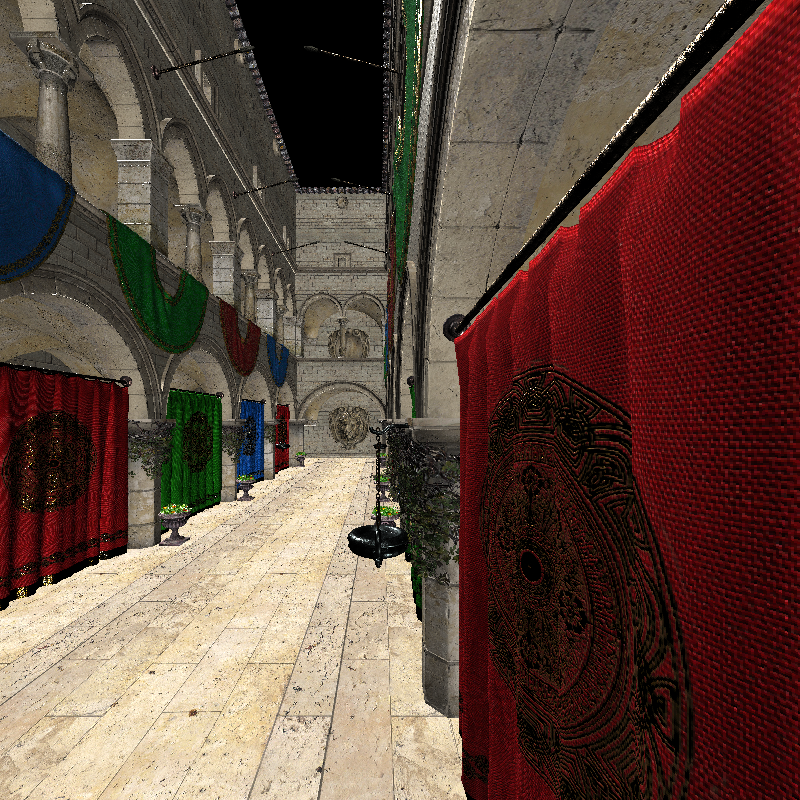

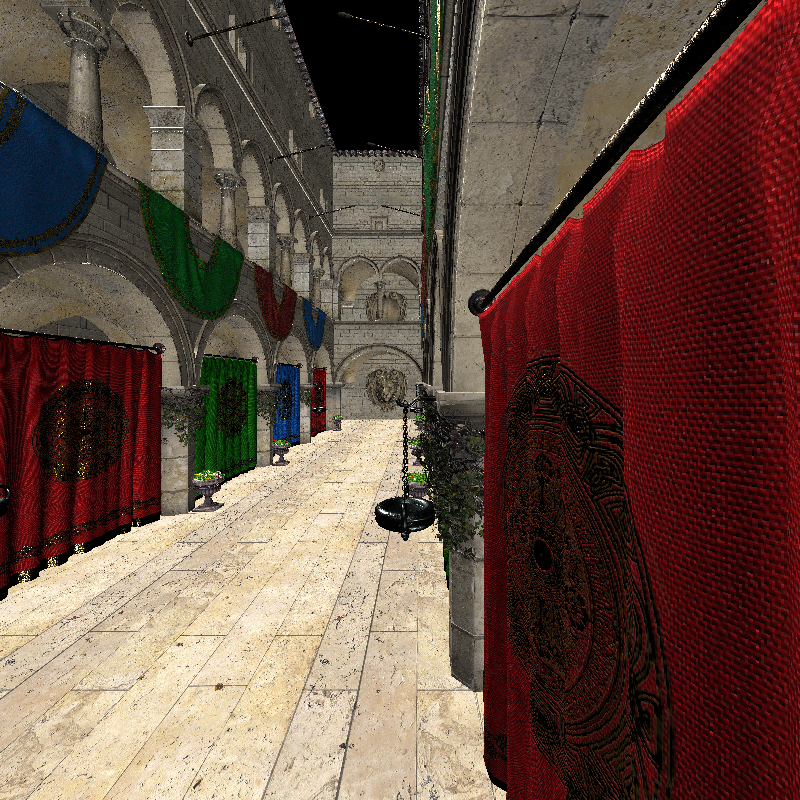

Wall time: 12.2 s


In [7]:
%%time

light_field = zarr.open('data/sponza_sampled_rt.zarr', mode='r')

first_view = np.zeros((n_chunk, chunk_v, n_chunk, chunk_v, 3), dtype=np.float32)
last_view  = np.zeros((n_chunk, chunk_v, n_chunk, chunk_v, 3), dtype=np.float32)

for idx_chunk, idy_chunk in tqdm(np.ndindex(n_chunk, n_chunk), total=light_field.nchunks):
    sample_values = light_field[:, idx_chunk, :, :, idy_chunk, :, :]

    first_view[idx_chunk, :, idy_chunk, :, :] = sample_values[ 0, :,  0, :, :]
    last_view[ idx_chunk, :, idy_chunk, :, :] = sample_values[-1, :, -1, :, :]

display_image(first_view.reshape(n_v, n_v, 3))
display_image( last_view.reshape(n_v, n_v, 3))